# Segmentation - Model

## 개요

### 실습 목표

* 시맨틱 세그멘테이션 데이터셋을 전처리할 수 있습니다.
* 시맨틱 세그멘테이션 모델을 만들고 학습할 수 있습니다.
* 시맨틱 세그멘테이션 모델의 결과를 시각화할 수 있습니다.

### 학습 내용

1. 시맨틱 세그멘테이션 데이터셋
2. 시맨틱 세그멘테이션 모델
3. 시맨틱 세그멘테이션 모델 시각화

## Semantic segmentation dataset

### 이미지, 데이터 가져오기

* 도로 영역을 라벨로 가진 데이터셋을 가지고 학습
* KITTI Dataset의 Segmentation data

### 데이터 로더(data loader) 가져오기

* loader의 입력값은 (224, 224), 출력값 (224, 224) 크기를 갖는 모델을 학습시킬 수 있도록 데이터셋을 파싱.
* Data loader에 augmentation 적용 - albumentations 사용(Augmentation의 경우 imgaug 등의 다른 라이브러리 활용가능)
* 학습셋의 일정량을 검증 데이터셋(validation dataset)으로 활용

### 라이브러리 로드

In [1]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

### Albumentation 활용

* Albumentation의 다양한 augmentation 기법을 확률적으로 적용할 수 있게 해주는 Compose()의 활용 예.
* imgaug의 Sometimes()와 유사한 기능
* Compose 의 list 안에 적용시켜줄 함수들을 넣어주면 됩니다.

In [2]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

* func(**data)라 하면
* data가 dict 일때 data의 value 값을 보냅니다.
* 이렇게 사용되려면 함수의 정의에서 사용한 파라미터의 값과 사용되는 dict의 key 값의 이름이 같아야 합니다.

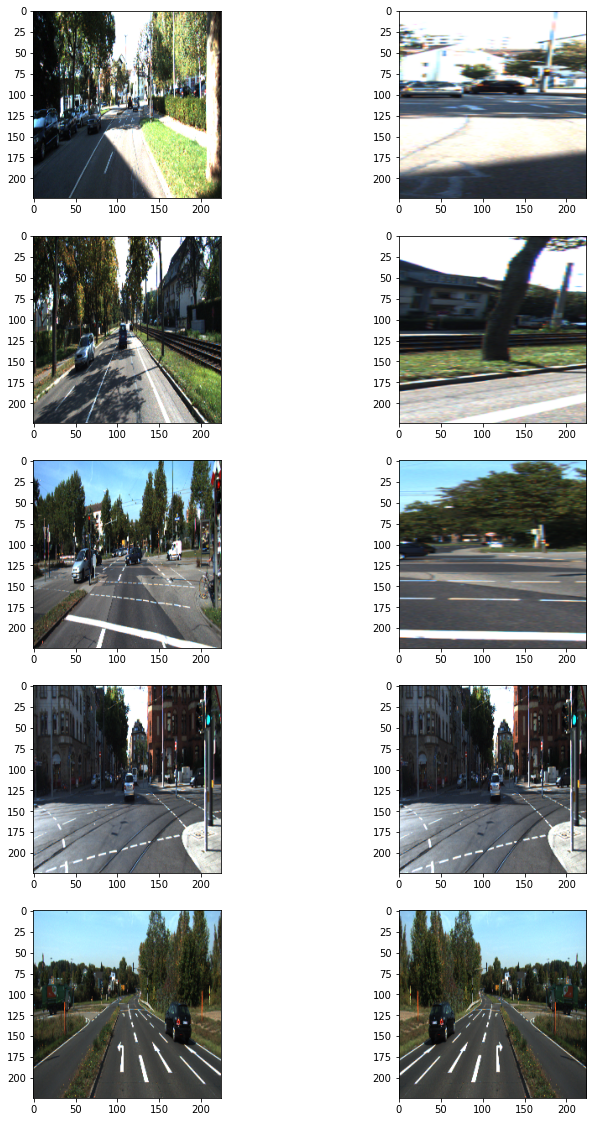

In [3]:
# dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'
dir_path = '/home/aiffel/Code/Going_Deeper/Going_Deeper_Project/4/data/KITTI/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
# 해당 디렉토리에 위치한 png 확장자의 파일들의 list를 가져옵니다.
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    # print(type(input_images[i]))
    # input_images = string 값
    image = imread(input_images[i])
    # print(type(image))
    # image = input_images 위치의 이미지를 읽어옴 = ndarray로 만듬
    image_data = {"image":image}
    # print(type(image_data))
    # 'image'를 key로 실제 이미지 데이터를 value로 가지는 dict 생성
    
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지

plt.show()

* 이제 데이터셋 구성해보기
* tf.keras.util.Sequence를 상속받은 generator 형태로 데이터 구성

In [4]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=16,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    # if self.is_train:
    #   return data[:-30]
    # return data[-30:]
  
    if self.is_train:
      return data[:-10]
    return data[-10:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [5]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

## Semantic segmentation model

### 모델 구조 만들기

* Semantic segmentation을 위한 모델 만들기
* 비교적 구현이 단순한 U-Net 만들기
* 입력이미지는 위에서 만든 데이터셋에 맞게 만들기
* 필요한 layer와 연산, 필요에 따라 Dropout 등의 다른 레이어 적용
1. Conv2D
2. Conv2DTranspose
3. Maxpooling2D
4. concatenate

<img src = 'image/U-Net_Architecture.png' width = 50% height = 50%>  
  
출처 : U-Net: Convolutional Networks for Biomedical paper  
화살표를 하나의 layer로 생각하고 모델을 생성해봅시다.

In [6]:
def build_model(input_shape=(224, 224, 3)):
  inputs = Input(input_shape)
	
  #Contracting Path
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  
  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  
  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
  
  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)
  
  #Expanding Path
  drop5 = Dropout(0.5)(conv5)
  up6 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop5)
  merge6 = concatenate([drop4,up6], axis = 3)
  
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
  up7 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv6)
  merge7 = concatenate([conv3,up7], axis = 3)
  
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
  up8 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv7)
  merge8 = concatenate([conv2,up8], axis = 3)
  
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
  up9 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv8)
  merge9 = concatenate([conv1,up9], axis = 3)
  
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
  conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
  conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
  
  model = Model(inputs = inputs, outputs = conv10)
  return model

### 모델 학습하기

* 모델을 만들었으니 데이터셋과 함께 학습할 수 있지만
* 미리 만들어진 모델으 불러와 봅시다.

In [7]:
# model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'
# model_path = '/home/aiffel/Code/Going_Deeper/Going_Deeper_Project/4/data/KITTI/training/seg_model_unet.h5'

# model = build_model()
# model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
# model.fit(
#      train_generator,
#      validation_data=test_generator,
#      steps_per_epoch=len(train_generator),
#      epochs=100,
#  )

# model.save(model_path)  #학습한 모델을 저장해 주세요.

### 미리 만들어진 모델 불러오기

In [8]:
model_path = dir_path + '/seg_model_unet.h5' 

model = tf.keras.models.load_model(model_path)

2022-10-19 19:45:35.322074: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-19 19:45:35.797261: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6668 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5


## Semantic segmentation 모델 시각화

* Test set은 이미지를 제공하지만 정답 데이터를 제공하지 않습니다.
* 눈으로 확인할 수 있도록 모델이 추론(inference)한 결과를 볼 수 있는 segmentation 이미지로 만들어주세요!
* 이때 입력이미지와 라벨을 한번에 볼 수 있도록 모델의 출력값을 입력 이미지 위에 겹쳐서 보이기, 즉 overray(오버레이) 해 주세요.
* PIL 패키지 사용시 Image.blend를 활용할 수 있습니다.
* threshold를 따로 parameter로 지정해주었습니다.

In [9]:
def get_output(model, preproc, image_path, output_path, threshold = 0.5):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    # output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255
    output = (output[0].numpy() > threshold).astype(np.uint8).squeeze(-1)*255 
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    # output.show()
    return output 

* 위의 작성한 함수를 이용해 시각화 해봅시다.

2022-10-19 19:45:37.734191: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204


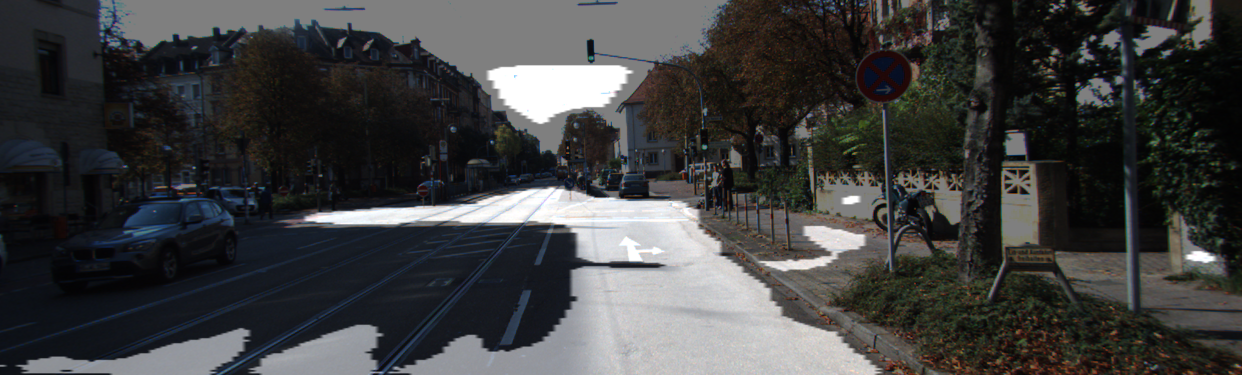

In [10]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
    model, 
    test_preproc,
    image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
    output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
    threshold=0.5
)

* IoU를 통해서 segmentation의 성능을 측정해봅시다.
* IoU 계산을 위해 모델이 도로라 판단한 부분을 1, 나머지를 0으로 표시한 행렬 그리고 라벨 데이터에서 도로 영역이 1, 나머지 부분이 0으로 표시된 행렬이 필요.
* 각각을 predict, target 이라 불렀을 때 이를 계산하는 함수를 구현

In [11]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [12]:
def get_output(model, preproc, image_path, output_path, label_path, threshold = 0.5):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy() >= threshold).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    # output.show()   # 도로로 판단한 영역을 시각화!
    
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

IoU : 0.757125


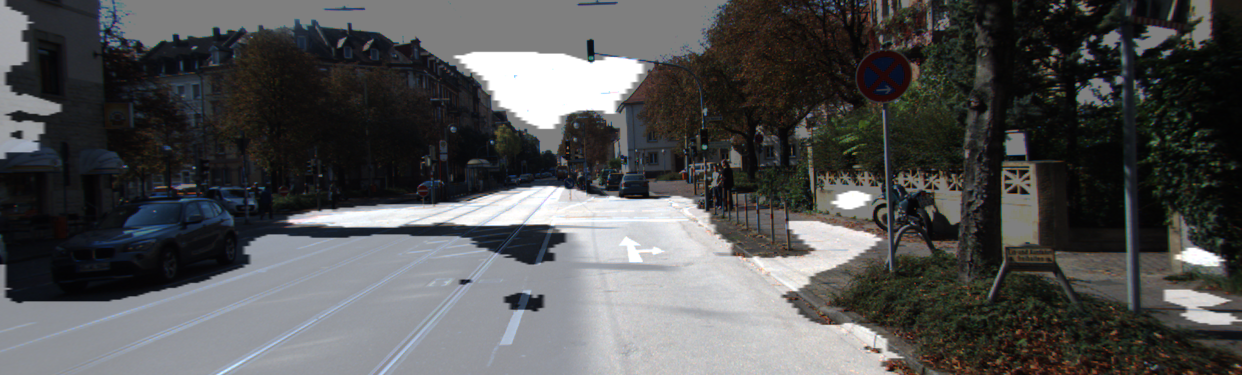

In [13]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png',
     threshold = 0.2
 )

calculate_iou_score(target, prediction)
output

## Project 개선된 U-Net 모델 만들기

* U-Net ++ 구현해보고 기존의 U-Net과 비교해봅시다.

### Step 1. KITTI 데이터셋 수집과 구축

* batch_size를 줄일 것을 권하고 있습니다.
* 기존 16에서 8로 줄여보겠습니다.

In [14]:
train_generator_4 = KittiGenerator(
    dir_path, 
    augmentation = augmentation,
    batch_size = 4
)

test_generator_4 = KittiGenerator(
    dir_path, 
    augmentation = test_preproc,
    is_train=False,
    batch_size = 4
)

### Step 2. U-Net++ 모델의 구현

* 기존의 U-Net에 skip pathway를 추가하는 것
* $x^{i,j}$ = node $X^{i,j}$의 출력값
* $i$ = encoder에서 down sampling layer의 index
* $j$ = skip pathway에서 dense block의 convolution layer의 index
* $x^{i,j}$로 표현된 feature map의 stack은 다음과 같이 계산됩니다.

$$ x^{i,j} = \begin{cases}H(x^{i-1,j}), & j = 0 \\ H([[x^{i,k}]^{j-1}_{k=0}, u(x^{i+1,j-1})]), & j > 0 \end{cases}$$

In [15]:
def build_ConvBlock(input_layer, channel, num):
    x = input_layer
    x = Conv2D(channel, 3, padding = 'same', kernel_initializer = 'he_normal', name = f'Conv{num}_1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(channel, 3, padding = 'same', kernel_initializer = 'he_normal', name = f'Conv{num}_2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [16]:
def build_UNetPlusPlus(input_shape=(224, 224, 3)):
  channel_size = [64,128,256,512,1024]
  
  inputs = Input(input_shape, name = 'input')
	
  # Contracting Path
  # 00 노드에서는 conv만 실행되고
  # pool을 적용해서 내려간다고 생각합시다.
  # 64, 0
  conv00 = build_ConvBlock(inputs, channel_size[0], '00')
  pool00to10 = MaxPooling2D(pool_size=(2, 2), name = 'pool00to10')(conv00)
  # 128, 1
  conv10 = build_ConvBlock(pool00to10, channel_size[1], '10')
  pool10to20 = MaxPooling2D(pool_size=(2, 2), name = 'pool10to20')(conv10)
  # 64, 0
  up10to01 = Conv2DTranspose(channel_size[0], 2, strides=(2,2), kernel_initializer='he_normal', name = 'up10to01', padding = 'same')(conv10)
  merge01 = concatenate([up10to01, conv00], axis = 3, name = 'merge01')
  conv01 = build_ConvBlock(merge01, channel_size[0], '01')
  # 256, 2
  conv20 = build_ConvBlock(pool10to20, channel_size[2], '20')
  pool20to30 = MaxPooling2D(pool_size=(2, 2), name = 'pool20to30')(conv20)
  # 128, 1
  up20to11 = Conv2DTranspose(channel_size[1], 2, strides=(2,2), kernel_initializer='he_normal', name = 'up20to11', padding = 'same')(conv20)
  merge11 = concatenate([up20to11, conv10], axis = 3, name = 'merge11')
  conv11 = build_ConvBlock(merge11, channel_size[1], '11')
  # 64, 0
  up11to02 = Conv2DTranspose(channel_size[0], 2, strides=(2,2), kernel_initializer='he_normal', name = 'up11to02', padding = 'same')(conv11)
  merge02 = concatenate([up11to02, conv00, conv01], axis = 3, name = 'merge02')
  conv02 = build_ConvBlock(merge02, channel_size[0], '02')
  # 512, 3
  conv30 = build_ConvBlock(pool20to30, channel_size[3], '30')
  pool30to40 = MaxPooling2D(pool_size=(2, 2), name = 'pool30to40')(conv30)
  # 256, 2
  up30to21 = Conv2DTranspose(channel_size[2], 2, strides=(2,2), kernel_initializer='he_normal', name = 'up30to21', padding = 'same')(conv30)
  merge21 = concatenate([up30to21, conv20], axis = 3, name = 'merge21')
  conv21 = build_ConvBlock(merge21, channel_size[2], '21')
  # 128, 1
  up21to12 = Conv2DTranspose(channel_size[1], 2, strides=(2,2), kernel_initializer='he_normal', name = 'up21to12', padding = 'same')(conv21)
  merge12 = concatenate([up21to12, conv10, conv11], axis = 3, name = 'merge12')
  conv12 = build_ConvBlock(merge12, channel_size[1], '12')
  # 64, 0
  up12to03 = Conv2DTranspose(channel_size[0], 2, strides=(2,2), kernel_initializer='he_normal', name = 'up12to03', padding = 'same')(conv12)
  merge03 = concatenate([up12to03, conv00, conv01, conv02], name = 'merge03')
  conv03 = build_ConvBlock(merge03, channel_size[0], '03')
  
  #Expanding Path
  # 1024, 4
  conv40 = build_ConvBlock(pool30to40, channel_size[4], '40')
  # 512, 3
  up40to31 = Conv2DTranspose(channel_size[3], 2, strides=(2,2), kernel_initializer='he_normal', name = 'up40to31', padding = 'same')(conv40)
  merge31 = concatenate([up40to31, conv30], axis = 3, name = 'merge31')
  conv31 = build_ConvBlock(merge31, channel_size[3], '31')
  # 256, 2
  up31to22 = Conv2DTranspose(channel_size[2], 2, strides=(2,2), kernel_initializer='he_normal', name = 'up31to22', padding = 'same')(conv31)
  merge22 = concatenate([up31to22, conv20, conv21], axis = 3, name = 'merge22')
  conv22 = build_ConvBlock(merge22, channel_size[2], '22')
  # 128, 1
  up22to13 = Conv2DTranspose(channel_size[1], 2, strides=(2,2), kernel_initializer='he_normal', name = 'up22to13', padding = 'same')(conv22)
  merge13 = concatenate([up22to13, conv10, conv11, conv12], axis = 3, name = 'merge13')
  conv13 = build_ConvBlock(merge13, channel_size[1], '13')
  # 64, 0
  up13to04 = Conv2DTranspose(channel_size[0], 2, strides=(2,2), kernel_initializer='he_normal', name = 'up13to04', padding = 'same')(conv13)
  merge04 = concatenate([up13to04, conv00, conv01, conv02, conv03], axis = 3, name = 'merge04')
  conv04 = build_ConvBlock(merge04 ,channel_size[0], '04')
  
  output = Conv2D(1, 1, activation='sigmoid', name = 'output')(conv04)
  
  model = Model(inputs = inputs, outputs = output)
  return model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv00_1 (Conv2D)              (None, 224, 224, 64  1792        ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 224, 224, 64  256        ['Conv00_1[0][0]']               
 alization)                     )                                                             

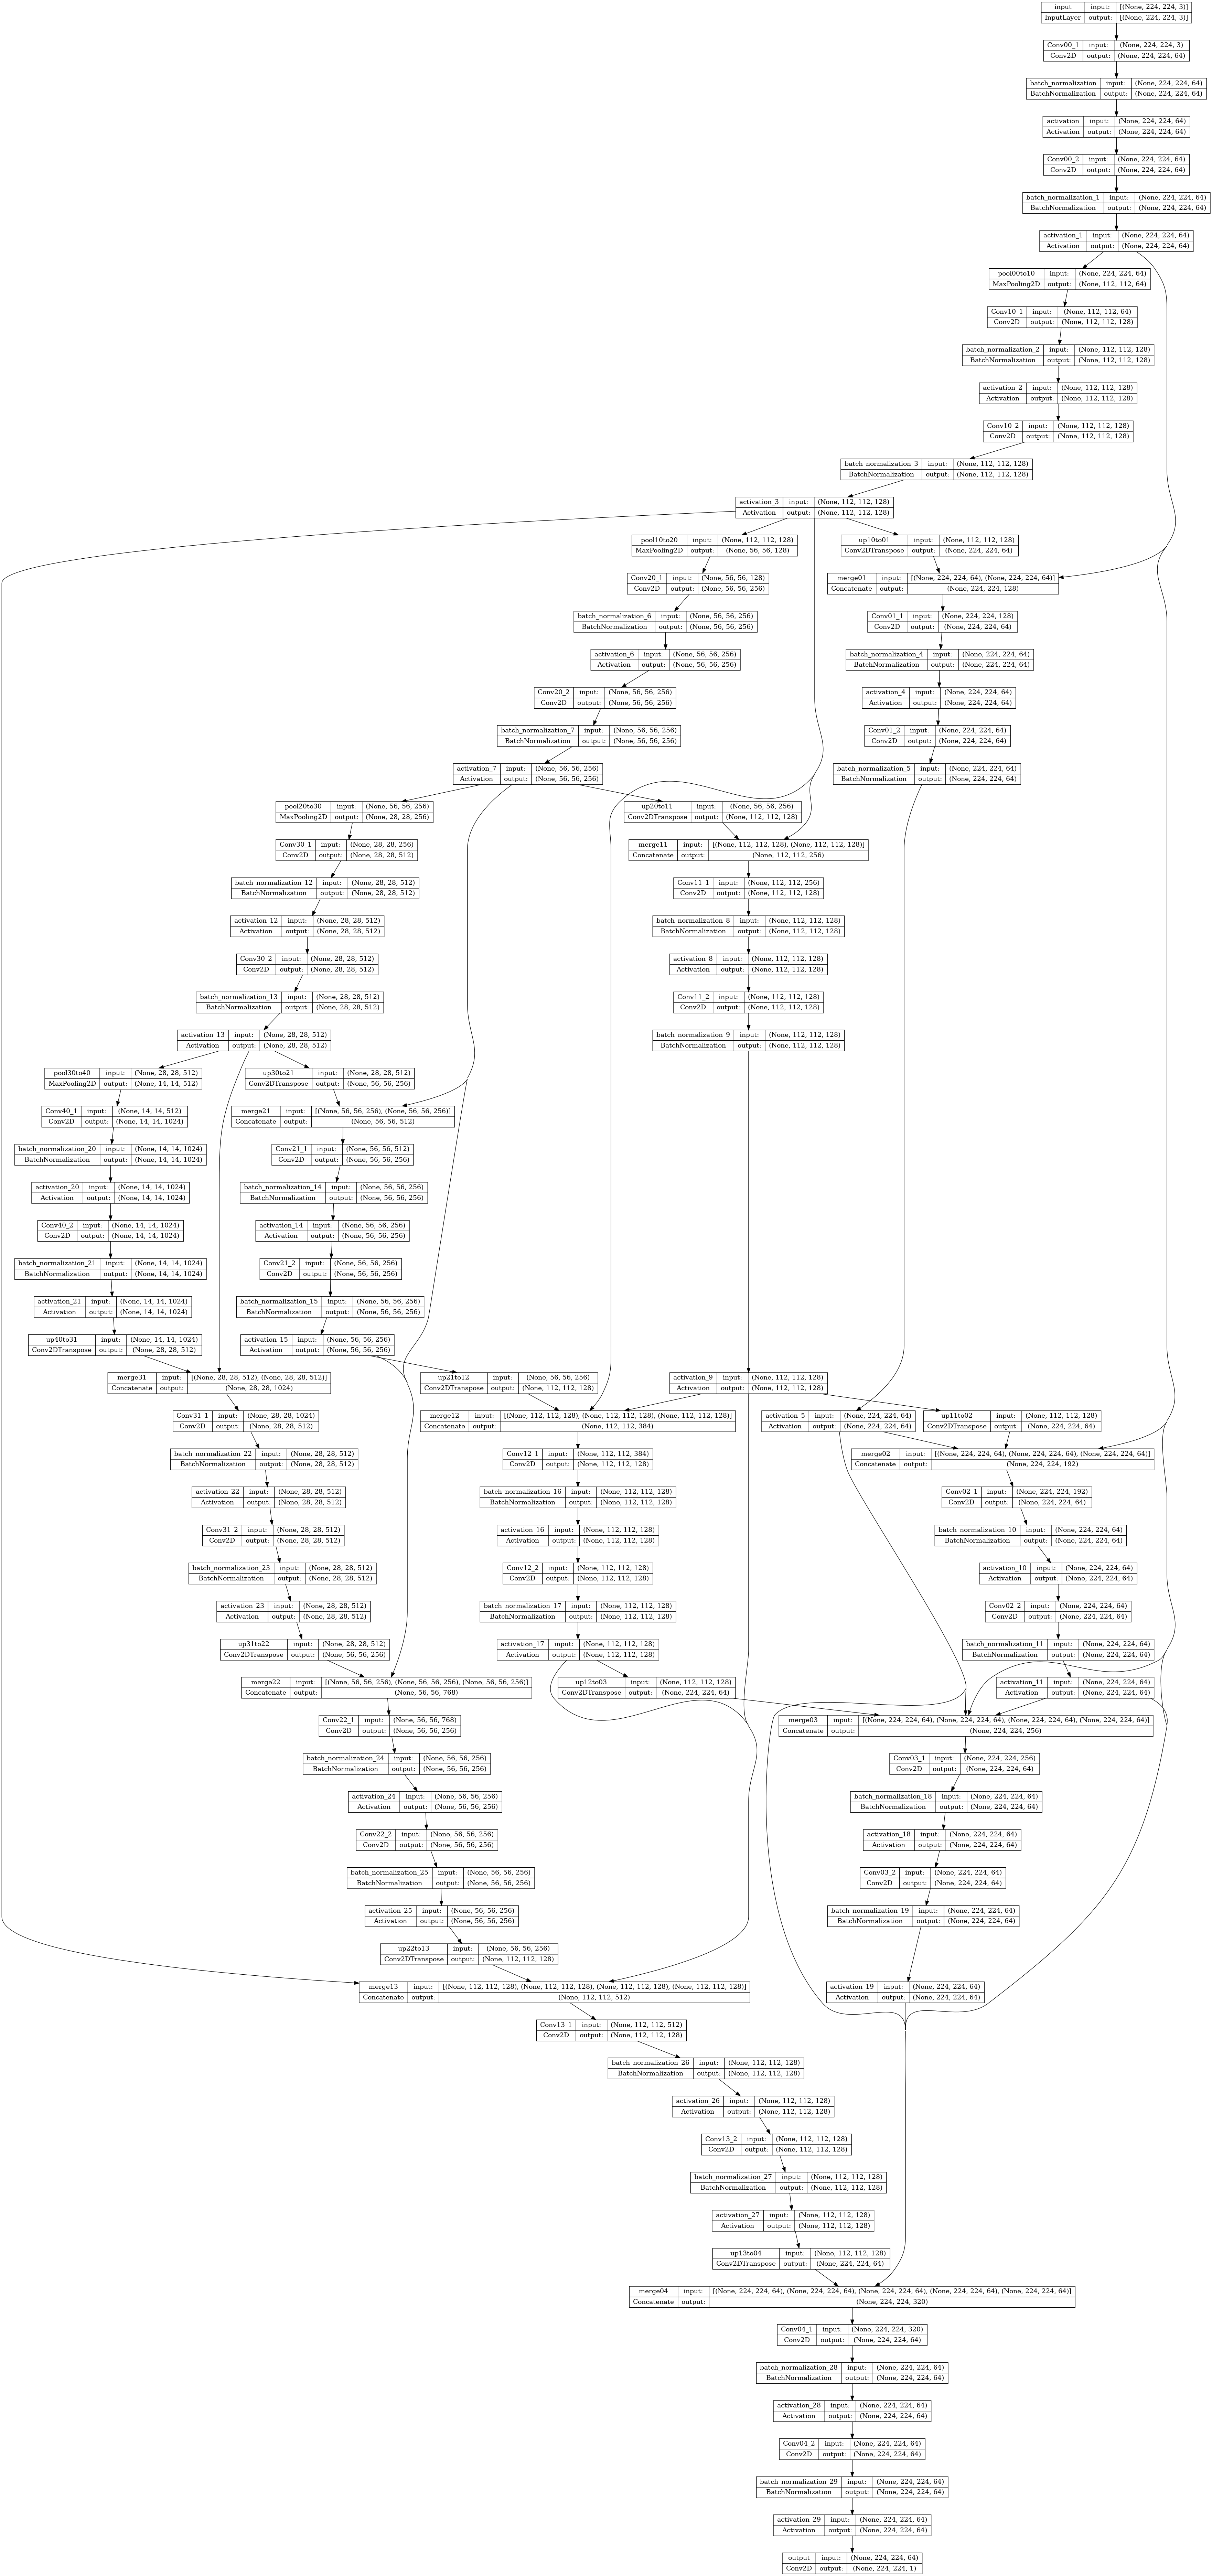

In [17]:
UNetPlusPlus = build_UNetPlusPlus()
UNetPlusPlus.summary()
tf.keras.utils.plot_model(UNetPlusPlus, show_shapes=True)

#### 확인

In [18]:
# def standard_unit(input_tensor, stage, nb_filter, kernel_size=3):
#     dropout_rate = 0.5
#     x = Conv2D(nb_filter, (kernel_size, kernel_size), activation='relu', name='conv'+stage+'_1', kernel_initializer = 'he_normal', padding='same')(input_tensor)
#     x = Dropout(dropout_rate, name='dp'+stage+'_1')(x)
#     x = Conv2D(nb_filter, (kernel_size, kernel_size), activation='relu', name='conv'+stage+'_2', kernel_initializer = 'he_normal', padding='same')(x)
#     x = Dropout(dropout_rate, name='dp'+stage+'_2')(x)

#     return x

In [19]:
# def UNetPlusPlusGit(input_shape=(224, 224, 3)):

#     # nb_filter = [32,64,128,256,512]
#     nb_filter = [64,128,256,512,1024]

#     # Handle Dimension Ordering for different backends
#     bn_axis = 3
#     inputs = Input(input_shape, name = 'input')

#     conv1_1 = standard_unit(inputs, stage='11', nb_filter=nb_filter[0])
#     pool1 = MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(conv1_1)

#     conv2_1 = standard_unit(pool1, stage='21', nb_filter=nb_filter[1])
#     pool2 = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(conv2_1)

#     up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(conv2_1)
#     conv1_2 = concatenate([up1_2, conv1_1], name='merge12', axis=bn_axis)
#     conv1_2 = standard_unit(conv1_2, stage='12', nb_filter=nb_filter[0])

#     conv3_1 = standard_unit(pool2, stage='31', nb_filter=nb_filter[2])
#     pool3 = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

#     up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
#     conv2_2 = concatenate([up2_2, conv2_1], name='merge22', axis=bn_axis)
#     conv2_2 = standard_unit(conv2_2, stage='22', nb_filter=nb_filter[1])

#     up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
#     conv1_3 = concatenate([up1_3, conv1_1, conv1_2], name='merge13', axis=bn_axis)
#     conv1_3 = standard_unit(conv1_3, stage='13', nb_filter=nb_filter[0])

#     conv4_1 = standard_unit(pool3, stage='41', nb_filter=nb_filter[3])
#     pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

#     up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
#     conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=bn_axis)
#     conv3_2 = standard_unit(conv3_2, stage='32', nb_filter=nb_filter[2])

#     up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
#     conv2_3 = concatenate([up2_3, conv2_1, conv2_2], name='merge23', axis=bn_axis)
#     conv2_3 = standard_unit(conv2_3, stage='23', nb_filter=nb_filter[1])

#     up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
#     conv1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], name='merge14', axis=bn_axis)
#     conv1_4 = standard_unit(conv1_4, stage='14', nb_filter=nb_filter[0])

#     conv5_1 = standard_unit(pool4, stage='51', nb_filter=nb_filter[4])

#     up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
#     conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=bn_axis)
#     conv4_2 = standard_unit(conv4_2, stage='42', nb_filter=nb_filter[3])

#     up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
#     conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=bn_axis)
#     conv3_3 = standard_unit(conv3_3, stage='33', nb_filter=nb_filter[2])

#     up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
#     conv2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], name='merge24', axis=bn_axis)
#     conv2_4 = standard_unit(conv2_4, stage='24', nb_filter=nb_filter[1])

#     up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
#     conv1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], name='merge15', axis=bn_axis)
#     conv1_5 = standard_unit(conv1_5, stage='15', nb_filter=nb_filter[0])

#     nestnet_output_4 = Conv2D(1, (1, 1), activation='sigmoid', name='output_4', kernel_initializer = 'he_normal', padding='same')(conv1_5)

#     model = Model(inputs, nestnet_output_4)

#     return model

In [20]:
# UNetPlusPlusGit = UNetPlusPlusGit()
# UNetPlusPlusGit.summary()
# tf.keras.utils.plot_model(UNetPlusPlusGit, show_shapes=True)

### 모델 학습하기

* loss

In [21]:
import keras
from keras import backend as K

def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1. - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)


In [22]:
model2_path = '/home/aiffel/Code/Going_Deeper/Going_Deeper_Project/4/data/KITTI/training/seg_model_unetplusplus.h5'

model2 = build_UNetPlusPlus()
model2.compile(optimizer="Adam", loss = bce_dice_loss, metrics = dice_coef)
model2.fit(
     train_generator_4,
     validation_data=test_generator_4,
     steps_per_epoch=len(train_generator_4),
     epochs=100,
 )

model2.save(model2_path)

Epoch 1/100


2022-10-19 19:45:49.540158: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.60GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-10-19 19:45:49.540196: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.60GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


48/48 [==============================] - 26s 357ms/step - loss: -0.1667 - dice_coef: 0.3315 - val_loss: 0.9124 - val_dice_coef: 0.4394
Epoch 2/100
48/48 [==============================] - 17s 348ms/step - loss: -0.3931 - dice_coef: 0.4720 - val_loss: 3.4427 - val_dice_coef: 0.2117
Epoch 3/100
48/48 [==============================] - 17s 350ms/step - loss: -0.5294 - dice_coef: 0.5877 - val_loss: -0.0918 - val_dice_coef: 0.2606
Epoch 4/100
48/48 [==============================] - 17s 352ms/step - loss: -0.3935 - dice_coef: 0.4587 - val_loss: -0.3464 - val_dice_coef: 0.4415
Epoch 5/100
48/48 [==============================] - 17s 352ms/step - loss: -0.5538 - dice_coef: 0.6180 - val_loss: -0.5695 - val_dice_coef: 0.7313
Epoch 6/100
48/48 [==============================] - 17s 352ms/step - loss: -0.6301 - dice_coef: 0.6810 - val_loss: -0.4336 - val_dice_coef: 0.5109
Epoch 7/100
48/48 [==============================] - 17s 352ms/step - loss: -0.6255 - dice_coef: 0.6829 - val_loss: -0.6523 - 

* 0.5로 threshold를 잡고 두 사진을 비교해보겠습니다.

In [27]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output2, prediction, target = get_output(
     model2, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png',
     threshold = 0.5
 )

calculate_iou_score(target, prediction)

IoU : 0.797467


0.7974667430462733

In [28]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png',
     threshold = 0.5
 )

calculate_iou_score(target, prediction)

IoU : 0.419641


0.41964089410040306

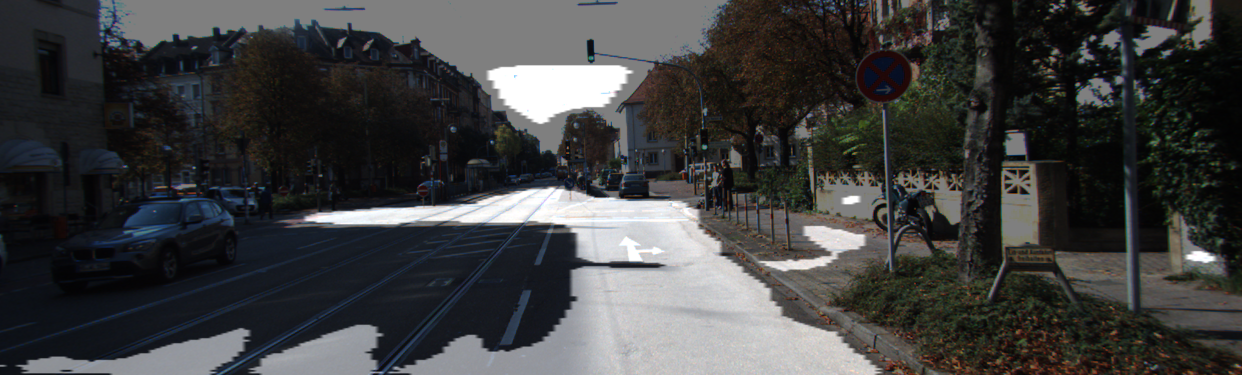

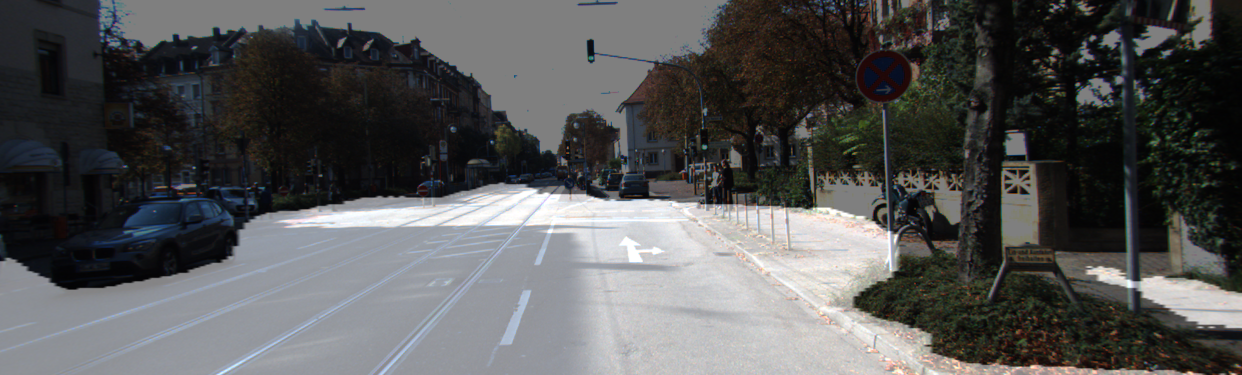

In [29]:
display(output)
display(output2)

* 비교해봤을 때 기존의 UNet은 하늘부분을 잡거나 건물 부분을 잡고 보도의 도로 구역은 잡지못했습니다.
* 하지만 UNet++은 대부분의 도로를 잡고 도로가 아닌 부분은 거의 잡지 않았습니다.
* 확실한 성능차이가 있습니다!

### 회고

* 이번 프로젝트에서 어려웠던 점
    - UNet++를 구현하는 것이 어려웠습니다.
* 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점
  * 알게 된점
    - Dropout 보다 BatchNormalization이 더 효율적일 수 있습니다.
  * 아직 모호한 점
    - UNet++의 세부적인 아키텍쳐
    - UNet++에서 Dropout 대신 BatchNormalization을 사용한 것
* 루브릭 평가를 맞추기 위해 시도한 점
    - Dropout을 활용해서 코드를 만들어보니 val_loss 값이 변하지 않는 문제점이 있어 batch_normalization을 dropout 대신 사용하였습니다.
    - 이미지 2개를 불러와서 비교해보았습니다.